<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Regression-Classification/blob/master/module4/assignment_regression_classification_4e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Installs
%%capture
!pip install --upgrade category_encoders plotly

In [141]:
# Imports
import os, sys

os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
!git pull origin master
    
os.chdir('module4')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Disable warning
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

### Load Data

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

### Train/Validate/Test Split

In [144]:
# Load initial train features and labels
from sklearn.model_selection import train_test_split
X_train = train_features
y_train = train_labels['status_group']

X_train.shape, y_train.shape

((59400, 40), (59400,))

In [145]:
# Split the initial train features and labels 80% into new train and new validation
X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, train_size = 0.80, test_size = 0.20,
  stratify = y_train, random_state=42
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [146]:
# Check values of new train labels
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [147]:
# Check values of new validation labels
y_val.value_counts(normalize=True)

functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64

### One-Hot Encoding - Quantity

In [148]:
# Check values of quantity feature
X_train['quantity'].value_counts(normalize=True)

enough          0.559070
insufficient    0.255745
dry             0.103556
seasonal        0.068266
unknown         0.013363
Name: quantity, dtype: float64

In [149]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train

train.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity      status_group           
dry           non functional             0.967689
              functional                 0.026011
              functional needs repair    0.006300
enough        functional                 0.650920
              non functional             0.276998
              functional needs repair    0.072082
insufficient  functional                 0.521106
              non functional             0.382786
              functional needs repair    0.096108
seasonal      functional                 0.580456
              non functional             0.318434
              functional needs repair    0.101110
unknown       non functional             0.713386
              functional                 0.267717
              functional needs repair    0.018898
Name: status_group, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Water Quantity')

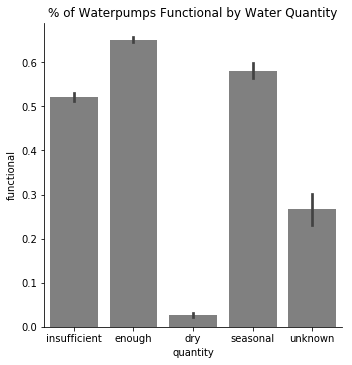

In [150]:
# Plot the values, dry shows a strong relationship to functional
import matplotlib.pyplot as plt
import seaborn as sns

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='quantity', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Water Quantity')

### One-Hot Encoding - Waterpoint Type

In [151]:
X_train['waterpoint_type'].value_counts(normalize=True)

communal standpipe             0.479335
hand pump                      0.294928
other                          0.108123
communal standpipe multiple    0.102357
improved spring                0.013279
cattle trough                  0.001873
dam                            0.000105
Name: waterpoint_type, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Waterpoint Type')

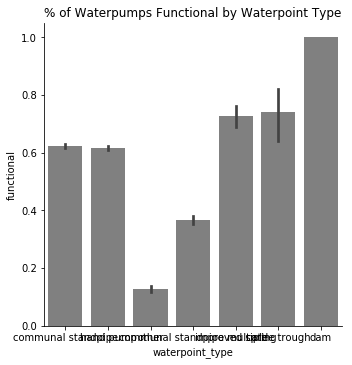

In [152]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train
train.groupby('waterpoint_type')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='waterpoint_type', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Waterpoint Type')

### One-Hot Encoding - Extraction Type

Text(0.5, 1.0, '% of Waterpumps Functional by Extraction Type')

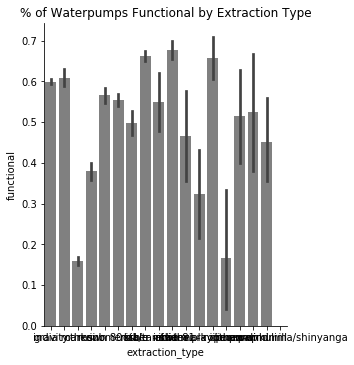

In [153]:
X_train['extraction_type'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('extraction_type')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='extraction_type', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Extraction Type')

### Bin and One-Hot Encoding - Installer

In [154]:
X_train['installer'] = X_train['installer'].str.lower()
X_val['installer'] = X_val['installer'].str.lower()

X_train['installer'] = X_train['installer'].str.lower()
X_val['installer'] = X_val['installer'].str.lower()

X_train['installer'] = X_train['installer'].str.replace('danid', 'danida')
X_val['installer'] = X_val['installer'].str.replace('danid', 'danida')

X_train['installer'] = X_train['installer'].str.replace('disti', 'district council')
X_val['installer'] = X_val['installer'].str.replace('disti', 'district council')

X_train['installer'] = X_train['installer'].str.replace('commu', 'community')
X_val['installer'] = X_val['installer'].str.replace('commu', 'community')

X_train['installer'] = X_train['installer'].str.replace('central government', 'government')
X_val['installer'] = X_val['installer'].str.replace('central government', 'government')

X_train['installer'] = X_train['installer'].str.replace('kkkt _ konde and dwe', 'kkkt')
X_val['installer'] = X_val['installer'].str.replace('kkkt _ konde and dwe', 'kkkt')

X_train['installer'].value_counts(normalize=True)
top10 = X_train['installer'].value_counts()[:5].index
X_train.loc[~X_train['installer'].isin(top10), 'installer'] = 'Other'
X_val.loc[~X_val['installer'].isin(top10), 'installer'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('installer')['status_group'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

installer   status_group           
Other       functional                 0.573994
            non functional             0.365113
            functional needs repair    0.060893
dwe         functional                 0.540558
            non functional             0.366452
            functional needs repair    0.092990
government  non functional             0.609583
            functional                 0.287476
            functional needs repair    0.102941
hesawa      functional                 0.563177
            non functional             0.396209
            functional needs repair    0.040614
kkkt        functional                 0.485380
            non functional             0.454971
            functional needs repair    0.059649
rwe         non functional             0.639583
            functional                 0.251042
            functional needs repair    0.109375
Name: status_group, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Installer')

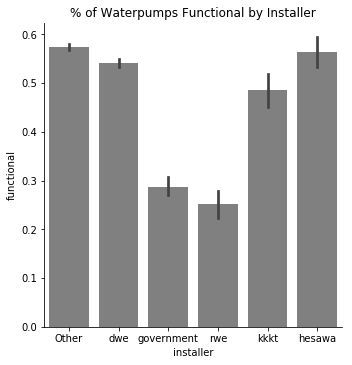

In [155]:
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='installer', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Installer')

### New Feature - Pump Age

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Text(0.5, 1.0, '% of Waterpumps Functional by Pump Age')

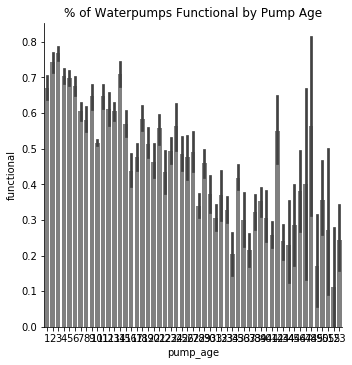

In [156]:
X_train['pump_age'] = 2013 - X_train['construction_year']
X_train.loc[X_train['pump_age'] == 2013, 'pump_age'] = 0
X_val['pump_age'] = 2013 - X_val['construction_year']
X_val.loc[X_val['pump_age'] == 2013, 'pump_age'] = 0

X_train.loc[X_train['pump_age'] == 0, 'pump_age'] = 10
X_val.loc[X_val['pump_age'] == 0, 'pump_age'] = 10

train = X_train.copy()
train['status_group'] = y_train

train.groupby('pump_age')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='pump_age', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Pump Age')

### Bin and One-Hot Encoding - Funder

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

Text(0.5, 1.0, '% of Waterpumps Functional by Funder')

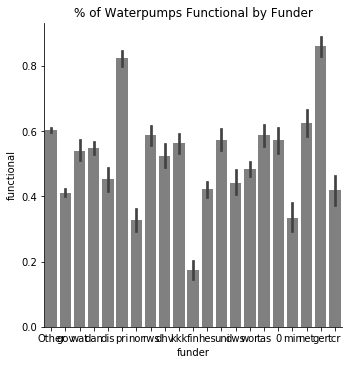

In [157]:
X_train['funder'] = X_train['funder'].str.lower()
X_val['funder'] = X_val['funder'].str.lower()

X_train['funder'] = X_train['funder'].str[:3]
X_val['funder'] = X_val['funder'].str[:3]

X_train['funder'].value_counts(normalize=True)
top10 = X_train['funder'].value_counts()[:20].index
X_train.loc[~X_train['funder'].isin(top10), 'funder'] = 'Other'
X_val.loc[~X_val['funder'].isin(top10), 'funder'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('funder')['status_group'].value_counts(normalize=True)

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='funder', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Funder')

### One-Hot Encoding - Water Quality

Text(0.5, 1.0, '% of Waterpumps Functional by Water Quality')

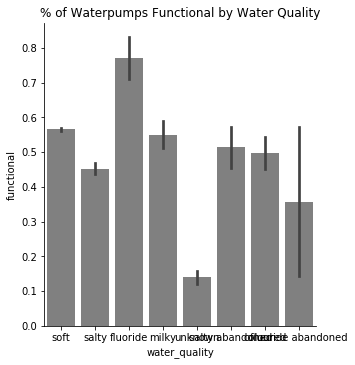

In [158]:
X_train['water_quality'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('water_quality')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='water_quality', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Water Quality')

### One-Hot Encoding - Basin

Text(0.5, 1.0, '% of Waterpumps Functional by Basin')

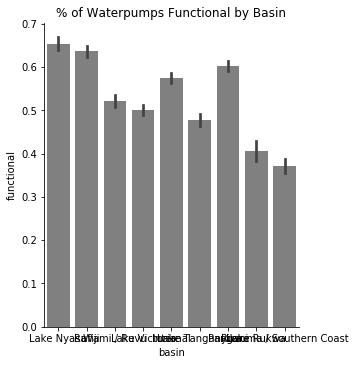

In [159]:
X_train['basin'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('basin')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='basin', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Basin')

### One-Hot Encoding - Region

Text(0.5, 1.0, '% of Waterpumps Functional by Region')

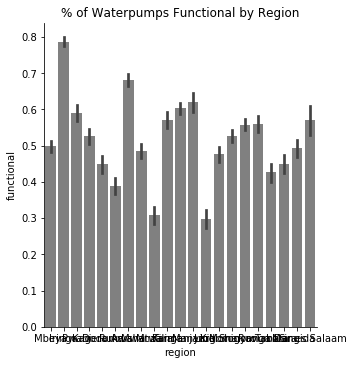

In [160]:
X_train['region'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('region')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='region', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Region')

### Use Mean for GPS Height Missing Values

In [161]:
X_train.loc[X_train['gps_height'] == 0, 'gps_height'] = X_train['gps_height'].mean()
X_val.loc[X_val['gps_height'] == 0, 'gps_height'] = X_val['gps_height'].mean()

train = X_train.copy()
train['status_group'] = y_train

train.groupby('gps_height')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']];

#sns.catplot(x='amount_tsh', y='functional', data=train, kind='bar', color='grey')
#plt.title('% of Waterpumps Functional by Pump Age')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### One-Hot Encoding - Payment

Text(0.5, 1.0, '% of Waterpumps Functional by Payment')

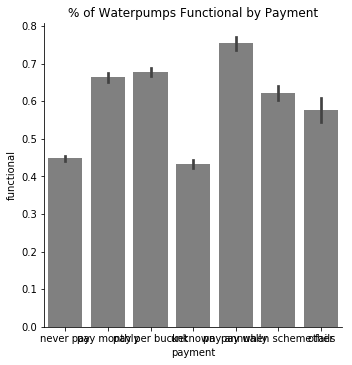

In [162]:
X_train['payment'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('payment')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='payment', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Payment')

### One-Hot Encoded - Source

Text(0.5, 1.0, '% of Waterpumps Functional by Source')

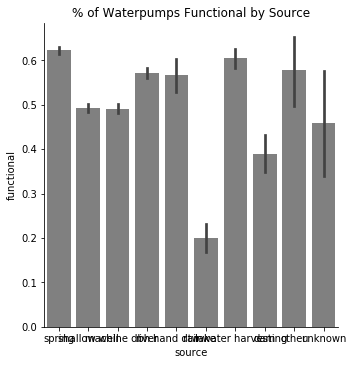

In [163]:
X_train['source'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('source')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='source', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Source')

### Bin and One-Hot Encoded - LGA

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, '% of Waterpumps Functional by LGA')

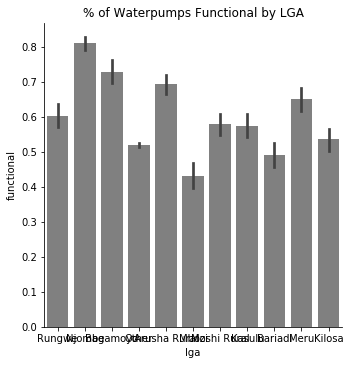

In [164]:
X_train['lga'].value_counts(normalize=True)
top10 = X_train['lga'].value_counts()[:10].index
X_train.loc[~X_train['lga'].isin(top10), 'lga'] = 'Other'
X_val.loc[~X_val['lga'].isin(top10), 'lga'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('lga')['status_group'].value_counts(normalize=True)

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='lga', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by LGA')

### Bin and One-Hot Encoded - Ward

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, '% of Waterpumps Functional by Ward')

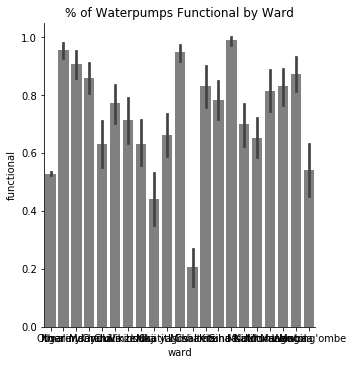

In [165]:
X_train['ward'].value_counts(normalize=True)
top10 = X_train['ward'].value_counts()[:20].index
X_train.loc[~X_train['ward'].isin(top10), 'ward'] = 'Other'
X_val.loc[~X_val['ward'].isin(top10), 'ward'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('ward')['status_group'].value_counts(normalize=True)

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='ward', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Ward')

### One-Hot Encode - Scheme Management

Text(0.5, 1.0, '% of Waterpumps Functional by Scheme Management')

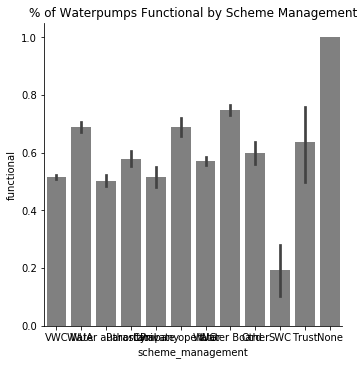

In [166]:
X_train['scheme_management'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('scheme_management')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='scheme_management', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Scheme Management')

### One-Hot Encode - Management

Text(0.5, 1.0, '% of Waterpumps Functional by Management')

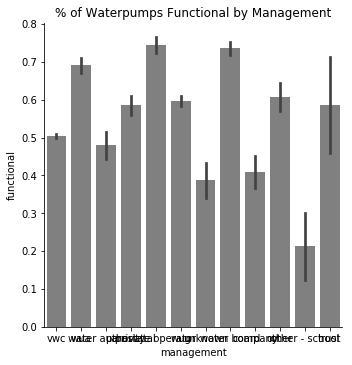

In [167]:
X_train['management'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('management')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='management', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Management')

### Create a Region/District Feature

Text(0.5, 1.0, '% of Waterpumps Functional by Region Code')

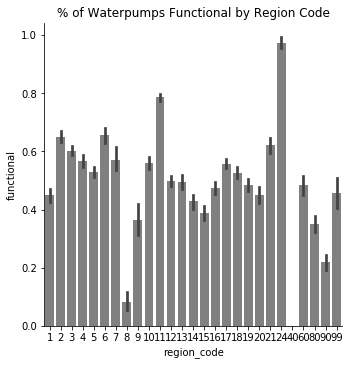

In [168]:
X_train['region_code'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('region_code')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='region_code', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Region Code')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, '% of Waterpumps Functional by Region/District')

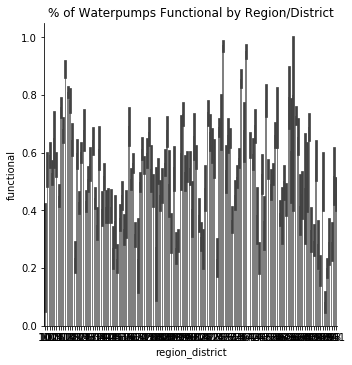

In [169]:
X_train['region_district'] = X_train['region_code'].astype(str) + X_train['district_code'].astype(str)
X_val['region_district'] = X_val['region_code'].astype(str) + X_val['district_code'].astype(str)

train = X_train.copy()
train['status_group'] = y_train

train.groupby('region_district')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='region_district', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Region/District')

### One-Hot Encode - Subvillage

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, '% of Waterpumps Functional by Subvillage')

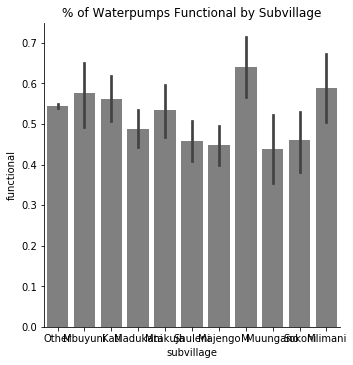

In [170]:
X_train['subvillage'].value_counts(normalize=True)
top10 = X_train['subvillage'].value_counts()[:10].index
X_train.loc[~X_train['subvillage'].isin(top10), 'subvillage'] = 'Other'
X_val.loc[~X_val['subvillage'].isin(top10), 'subvillage'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('subvillage')['status_group'].value_counts(normalize=True)

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='subvillage', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Subvillage')

### One-Hot Encoding - Water Quality

Text(0.5, 1.0, '% of Waterpumps Functional by Quality')

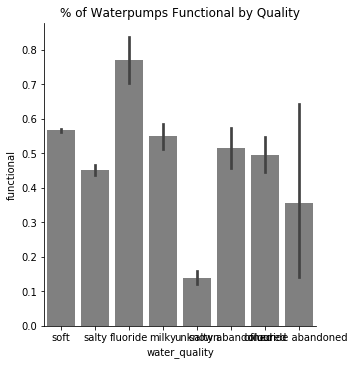

In [171]:
X_train['water_quality'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('water_quality')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='water_quality', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Quality')

### Lat/Long Cleanup

In [172]:
#test['region'].value_counts()
average_lat = X_train.groupby('region').latitude.mean().reset_index()
average_long = X_train.groupby('region').longitude.mean().reset_index()

shinyanga_lat = average_lat.loc[average_lat['region'] == 'Shinyanga', 'latitude']
shinyanga_long = average_long.loc[average_lat['region'] == 'Shinyanga', 'longitude']

X_train.loc[(X_train['region'] == 'Shinyanga') & (X_train['latitude'] > -1), ['latitude']] = shinyanga_lat[17]
X_train.loc[(X_train['region'] == 'Shinyanga') & (X_train['longitude'] == 0), ['longitude']] = shinyanga_long[17]

mwanza_lat = average_lat.loc[average_lat['region'] == 'Mwanza', 'latitude']
mwanza_long = average_long.loc[average_lat['region'] == 'Mwanza', 'longitude']

X_train.loc[(X_train['region'] == 'Mwanza') & (X_train['latitude'] > -1), ['latitude']] = mwanza_lat[13]
X_train.loc[(X_train['region'] == 'Mwanza') & (X_train['longitude'] == 0) , ['longitude']] = mwanza_long[13]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Impute Amount TSH

In [0]:
def tsh_calc(tsh, source, base, waterpoint):
  if tsh == 0:
    if (source, base, waterpoint) in test_dict:
      new_tsh = tsh_dict[source, base, waterpoint]
      return new_tsh
  else:
    return tsh
  
  return tsh

In [174]:
temp = X_train[X_train['amount_tsh'] != 0].groupby(['source_class',
                                                    'basin',
                                                    'waterpoint_type_group'])['amount_tsh'].mean()

tsh_dict = dict(temp)
X_train['amount_tsh'] = X_train.apply(lambda x: tsh_calc(x['amount_tsh'], x['source_class'], x['basin'], x['waterpoint_type_group']), axis=1)
#X_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
#X_train.loc[X_train['amount_tsh'] == 0, 'amount_tsh'] = X_train['amount_tsh'].median()
#X_val.loc[X_val['amount_tsh'] == 0, 'amount_tsh'] = X_val['amount_tsh'].median()

train = X_train.copy()
train['status_group'] = y_train

train.groupby('amount_tsh')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']];

In [0]:
#X_train.loc[X_train['public_meeting'].isnull(), 'public_meeting'] = False
#X_val.loc[X_val['public_meeting'].isnull(), 'public_meeting'] = False

#train = X_train.copy()
#train['status_group'] = y_train

#train.groupby('public_meeting')['status_group'].value_counts(normalize=True)
#train['functional']= (train['status_group'] == 'functional').astype(int)
#train[['status_group', 'functional']];

#sns.catplot(x='public_meeting', y='functional', data=train, kind='bar', color='grey')
#plt.title('% of Waterpumps Functional by Region/District')

### Run the Logistic Regression

In [0]:
import sklearn
sklearn.__version__

# Import the class
from sklearn.linear_model import LogisticRegressionCV

# Import package and scaler
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [178]:
# use quantity feature and the numerical features but drop id
categorical_features = ['quantity', 'waterpoint_type', 'extraction_type', 'installer',
                         'basin', 'region', 'payment', 'source', 'lga', 'public_meeting',
                         'scheme_management', 'permit', 'management', 'region_district',
                         'subvillage', 'funder', 'water_quality', 'ward']
                                             
# 
numeric_features = X_train.select_dtypes('number').columns.drop('id').drop('num_private').tolist()
features = categorical_features + numeric_features

# make subsets using the quantity feature all numeric features except id
X_train_subset = X_train[features]
X_val_subset = X_val[features]

# Do the encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

# Use the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# Fit the model and check the accuracy
model = LogisticRegressionCV(n_jobs = -1)
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val));



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Validation Accuracy 0.7555555555555555


### Run RandomForestClassifier

In [179]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, 
                               random_state=42,
                               max_features = 'auto',
                               n_jobs=-1,
                               verbose = 1)

model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val));



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.8s


Validation Accuracy 0.8093434343434344


[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    4.7s finished


In [180]:
test_features['pump_age'] = 2013 - test_features['construction_year']
test_features.loc[test_features['pump_age'] == 2013, 'pump_age'] = 0

test_features['region_district'] = test_features['region_code'].astype(str) + test_features['district_code'].astype(str)

test_features.drop(columns=['num_private'])

X_test_subset = test_features[features]
X_test_encoded = encoder.transform(X_test_subset)
X_test_scaled = scaler.transform(X_test_encoded)
assert all(X_test_encoded.columns == X_train_encoded.columns)

y_pred = model.predict(X_test_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    4.4s finished


In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/content/submission-01.csv', index=False)